## Evaluate

In [1]:
#! apt-get update
#! sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#! apt install cm-super
#!pip install chainconsumer

In [ ]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
import pylab as plt
import scipy.stats
from matplotlib.patches import Ellipse

# Colab in order to download files
from google.colab import files


# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Tensorflow and Keras
import tensorflow as tf
import tensorflow_probability as tfp


from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# Import some layers etc that are useful in the Functional approach
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

In [ ]:
# Mount drive to upload/download the datasets
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
# Images
#X_train = np.float64(np.load("/content/drive/My Drive/BNN_final_codes/X_train.npy"))
X_test = np.float64(np.load("/content/drive/My Drive/BNN_final_codes/X_test.npy"))


# Labels
y_train = np.float64(np.load("/content/drive/My Drive/BNN_final_codes/y_train.npy"))
y_test = np.float64(np.load("/content/drive/My Drive/BNN_final_codes/y_test.npy"))

In [ ]:
scaler = StandardScaler()

# Rescale the labels
scaler.fit(y_train)
y_train_sc = scaler.transform(y_train)
y_test_sc = scaler.transform(y_test)

In [ ]:
# Define basic numbers
IMAGE_SHAPE = [64, 64, 3]
NUM_TRAIN_EXAMPLES = 100000
NUM_VAL_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 20000
NUM_CLASSES = 5

In [ ]:
tfd = tfp.distributions

# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn on
# flipout layers.
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                           tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

In [ ]:
# Bayesian DeepShadows in functional form
model_input = Input(shape=(64,64,3))
# Convolutional part =================
# 1st convolutional chunk 
x = tfp.layers.Convolution2DFlipout(
          filters = 4, 
          kernel_size=(3,3),
          #activity_regularizer = regularizers.l2(0.005),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(model_input)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 2nd convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 8, 
          kernel_size=(3,3),
          #activity_regularizer = regularizers.l2(0.005),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 3rd convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 16, 
          kernel_size=(3,3),
          #activity_regularizer = regularizers.l2(0.005),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 4th convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 32, 
          kernel_size=(3,3),
          #activity_regularizer = regularizers.l2(0.005),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)


# 5th convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 64, 
          kernel_size=(3,3),
          #activity_regularizer = regularizers.l2(0.005),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)                    
# ====================================
x = keras.layers.Flatten()(x)
# ====================================
x = tfp.layers.DenseFlipout(
          units = 1024,
          #activity_regularizer = regularizers.l2(0.012),
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = tfp.layers.DenseFlipout(
          units = 512,
          #activity_regularizer = regularizers.l2(0.012),
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
distribution_params = keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(5))(x)
model_output = tfp.layers.MultivariateNormalTriL(event_size=5)(distribution_params)
model = Model(model_input, model_output)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


In [ ]:
model.load_weights('/content/drive/My Drive/BNN_final_codes/BNN_weights.h5')

In [ ]:
i = 150
X_0 = X_test[i]
y_0 = y_test[i]
print(y_0)

[125.8829407    0.44367861   0.96676577  13.24661744  12.55411975]


In [ ]:
pred_dist = model(X_0.reshape(1,64,64,3))


In [ ]:
prediction_mean = pred_dist.mean().numpy()[0]
prediction_cov = pred_dist.covariance().numpy()[0]
print(prediction_mean)
print(prediction_cov)
preds = np.random.multivariate_normal(prediction_mean,prediction_cov,300)

[ 0.80469704  0.32242826 -0.76518077 -1.2102115  -0.86907405]
[[ 4.9644363e-08  2.7689767e-08  3.9111390e-09  4.5892070e-06
   8.8939498e-07]
 [ 2.7689767e-08  3.6702854e-08  2.5398285e-06  3.9070151e-06
  -1.0768543e-06]
 [ 3.9111390e-09  2.5398285e-06  3.0297047e-04  1.6356676e-04
  -1.9043250e-04]
 [ 4.5892070e-06  3.9070151e-06  1.6356676e-04  6.2372943e-04
  -1.4668639e-04]
 [ 8.8939498e-07 -1.0768543e-06 -1.9043250e-04 -1.4668639e-04
   5.0307799e-04]]


In [ ]:
print(np.shape(prediction_mean))

(5,)


In [ ]:
n_rands = 700
for i in range(n_rands):
  pred_dist = model(X_0.reshape(1,64,64,3))
  prediction_mean = pred_dist.mean().numpy()[0]
  prediction_cov = pred_dist.covariance().numpy()[0]
  preds_loc = np.random.multivariate_normal(prediction_mean,prediction_cov,500)
  preds = np.concatenate((preds,preds_loc))

In [ ]:
#!pip install chainconsumer
from chainconsumer import ChainConsumer

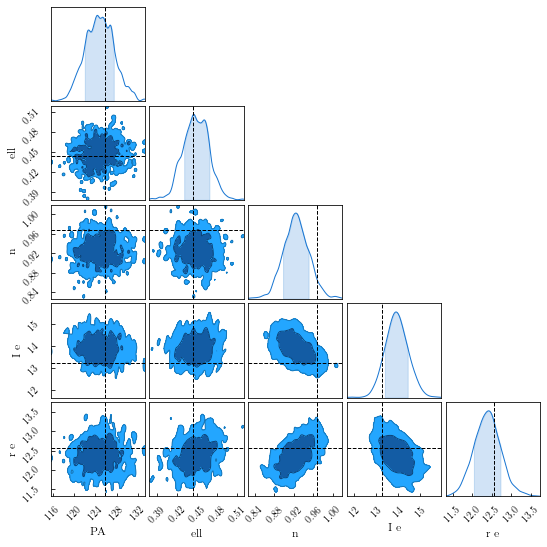

In [ ]:
#y_0_new = scaler.inverse_transform(y_0.reshape(-1,5))

preds_new = scaler.inverse_transform(np.asarray(preds))

c = ChainConsumer()
c.add_chain(preds_new,parameters=["PA", "ell", "n", "I e", "r e"])
fig = c.plotter.plot(figsize=(8,8), truth=y_0)

### Run for a series of galaxies

In [ ]:
n_test = 1000

X_keep = X_test[:n_test]
y_keep = y_test[:n_test]
y_keep_sc = y_test_sc[:n_test]

print(np.shape(X_keep))

(1000, 64, 64, 3)


In [ ]:
pred_dist = model(X_keep)

In [ ]:
print(pred_dist)

tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1000], event_shape=[5], dtype=float32)


In [ ]:
sample = np.asarray(pred_dist.sample(300))

In [ ]:
print(np.shape(sample))

(300, 1000, 5)


In [ ]:
n_rands = 800
for i in range(n_rands):
  pred_dist = model(X_keep)
  sample_loc = np.asarray(pred_dist.sample(300))
  sample = np.concatenate((sample,sample_loc))

In [ ]:
print(np.shape(sample))

(240300, 1000, 5)


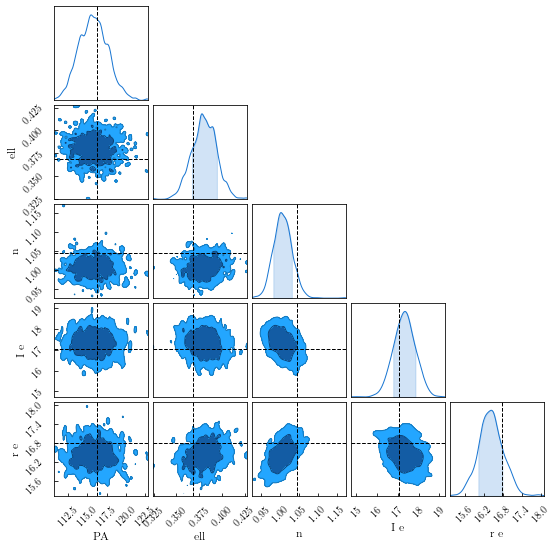

In [ ]:
sample_new = scaler.inverse_transform(np.asarray(sample[:,0,:]))

c = ChainConsumer()
c.add_chain(sample_new,parameters=["PA", "ell", "n", "I e", "r e"])
fig = c.plotter.plot(figsize=(8,8), truth=y_keep[0])

### **Predicted and true effective radius**

In [ ]:
inv_sample = []

for i in range(n_test):
  inv_sample_loc = scaler.inverse_transform(sample[:,i,:])
  inv_sample.append(inv_sample_loc)

In [ ]:
print(np.shape(inv_sample))

(1000, 240300, 5)


In [ ]:
# Get means
mean_preds = scaler.inverse_transform(np.mean(sample,axis=0))
# Get standard deviations
std_preds = (np.std(inv_sample,axis=1))

print(np.shape(std_preds))

(1000, 5)


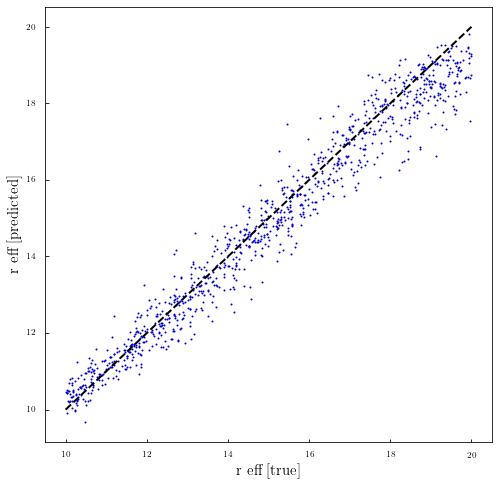

In [ ]:
x = np.linspace(10,20,100)


plt.figure(figsize=(8., 8.0))


plt.scatter(y_keep[:,-1], mean_preds[:,-1],c='mediumblue',s=1.0)
plt.plot(x,x,ls='--',c='k',linewidth=2)


plt.xlabel('r eff [true]',fontsize=15);plt.ylabel('r eff [predicted]', fontsize=15)

plt.show()

In [ ]:
pull_effect = (mean_preds[:,-1]-y_keep[:,-1])/std_preds[:,-1]

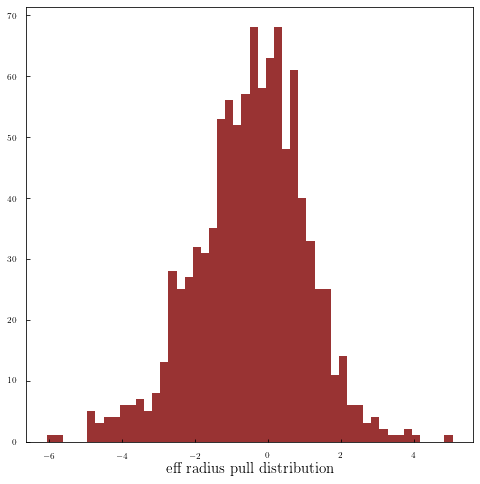

In [ ]:
plt.figure(figsize=(8., 8.0))

plt.hist(pull_effect,bins=50,color='maroon',alpha=0.8)


plt.xlabel('eff radius pull distribution',fontsize=15)
plt.show()

In [ ]:
pull_n = (mean_preds[:,-3]-y_keep[:,-3])/std_preds[:,-3]

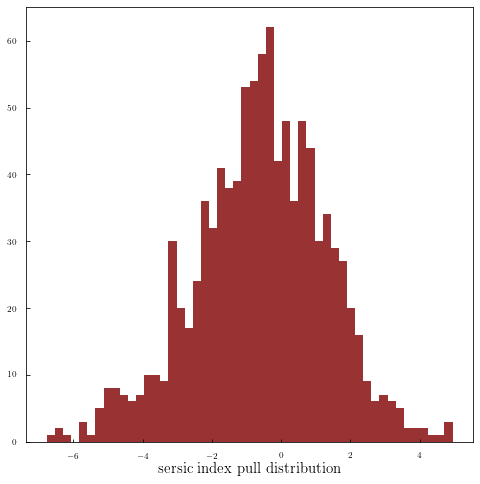

In [ ]:
plt.figure(figsize=(8., 8.0))

plt.hist(pull_n,bins=50,color='maroon',alpha=0.8)


plt.xlabel('sersic index pull distribution',fontsize=15)
plt.show()

In [ ]:
pull_Ie = (mean_preds[:,-2]-y_keep[:,-2])/std_preds[:,-2]

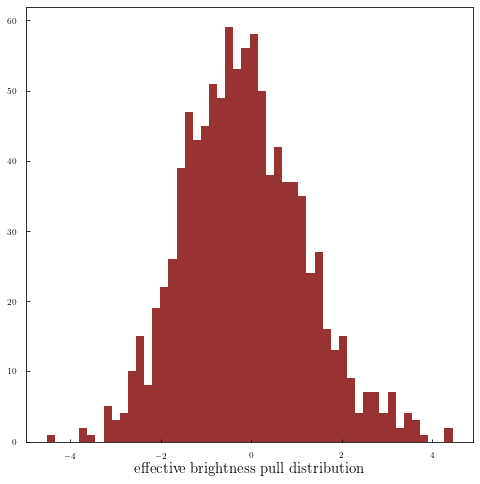

In [ ]:
plt.figure(figsize=(8., 8.0))

plt.hist(pull_Ie,bins=50,color='maroon',alpha=0.8)


plt.xlabel('effective brightness pull distribution',fontsize=15)
plt.show()

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)